In [1]:
from pyspark.sql import SparkSession
spark = SparkSession \
.builder \
.appName("Read Voter File Data") \
.getOrCreate()

df = (
spark.read
    .format("parquet")
    .option("header", "true")
    .option("inferSchema", "true")
    .load("gs://winter-2024-voter-file/VM2Uniform/VM2Uniform--PA--2021-05-20")
)
# 8359764 rows befor cleaning

24/03/18 21:41:22 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


The first step is to clean the data. We selected the columns we would use later and remove the null data. 
For simplicity, we would only focus on the Democratic and Republican party and ignore all other party voters.

In [2]:
df = df[df.Voters_Active == "A"]

In [3]:
df = df[df.Voters_VotingPerformanceEvenYearGeneral != "Not Eligible"]

In [4]:
df = df.filter(df["CommercialData_EstimatedHHIncomeAmount"].isNotNull())

In [5]:
df = df.filter(df["CommercialData_ISPSA"].isNotNull())

In [6]:
df = df.filter(df["Voters_Age"].isNotNull())

In [7]:
df = df.filter(df["EthnicGroups_EthnicGroup1Desc"].isNotNull())

In [8]:
df = df[(df.Parties_Description == "Republican") | (df.Parties_Description == "Democratic")]

In [9]:
df = df.filter(df["CommercialData_EstHomeValue"].isNotNull())

In [10]:
df.count()
# after cleaning still over 5 million rows, data is enough

5699424

The next step is to turn the data from string to intergers and and dummy variables for categorical data.

In [11]:
import pyspark.sql.functions as f
from pyspark.sql.types import IntegerType
df = df.withColumn('Participation', f.regexp_replace('Voters_VotingPerformanceEvenYearGeneral', '[%]', '').cast('int'))
df = df.withColumn('Income', f.regexp_replace('CommercialData_EstimatedHHIncomeAmount', '[$]', '').cast('int'))
df = df.withColumn('Home_Value', f.regexp_replace('CommercialData_EstHomeValue', '[$]', '').cast('int'))
df = df.withColumn('Age', df.Voters_Age.cast('int'))
df = df.withColumn('Family_Head_Count', df.Residence_Families_HHCount.cast('int'))
df = df.withColumn('ISPSA', df.CommercialData_ISPSA.cast('int'))

In [12]:
df = df.na.fill("no")

In [13]:
from pyspark.ml.feature import StringIndexer
df = StringIndexer(inputCol="Parties_Description",outputCol="Party_index").fit(df).transform(df)
df = StringIndexer(inputCol="MaritalStatus_Description",outputCol="Marital_index").fit(df).transform(df)
df = StringIndexer(inputCol="EthnicGroups_EthnicGroup1Desc",outputCol="Ethnic_index").fit(df).transform(df)
df = StringIndexer(inputCol="CommercialDataLL_Gun_Owner",outputCol="Gun_index").fit(df).transform(df)
df = StringIndexer(inputCol="CommercialDataLL_Home_Owner_Or_Renter",outputCol="House_index").fit(df).transform(df)

In [14]:
from pyspark.ml.feature import OneHotEncoder
df = OneHotEncoder(inputCols=['Party_index'], outputCols=['Party_dummy']).fit(df).transform(df)
df = OneHotEncoder(inputCols=['Marital_index'], outputCols=['Marital_dummy']).fit(df).transform(df)
df = OneHotEncoder(inputCols=['Ethnic_index'], outputCols=['Ethnic_dummy']).fit(df).transform(df)
df = OneHotEncoder(inputCols=['Gun_index'], outputCols=['Gun_ownership_dummy']).fit(df).transform(df)
df = OneHotEncoder(inputCols=['House_index'], outputCols=['Home_ownership_dummy']).fit(df).transform(df)

In [15]:
df = df.withColumn('Party', df.Parties_Description)
df = df.withColumn('Marital', df.MaritalStatus_Description)
df = df.withColumn('Ethnic', df.EthnicGroups_EthnicGroup1Desc)
df = df.withColumn('Gun_ownership', df.CommercialDataLL_Gun_Owner)
df = df.withColumn('Home_ownership', df.CommercialDataLL_Home_Owner_Or_Renter)

In [16]:
voter_df = df["Participation", "Party", "Party_dummy", "Age", "Marital", "Marital_dummy", "Family_Head_Count", "Ethnic", "Ethnic_dummy",
              "Income", "ISPSA", "Gun_ownership", "Gun_ownership_dummy", "Home_ownership", "Home_ownership_dummy", "Home_value"]

In [17]:
voter_df.show()

+-------------+----------+-------------+---+---------------+-------------+-----------------+--------------------+-------------+------+-----+-------------+-------------------+----------------+--------------------+----------+
|Participation|     Party|  Party_dummy|Age|        Marital|Marital_dummy|Family_Head_Count|              Ethnic| Ethnic_dummy|Income|ISPSA|Gun_ownership|Gun_ownership_dummy|  Home_ownership|Home_ownership_dummy|Home_value|
+-------------+----------+-------------+---+---------------+-------------+-----------------+--------------------+-------------+------+-----+-------------+-------------------+----------------+--------------------+----------+
|          100|Democratic|(1,[0],[1.0])| 50|Non-Traditional|    (2,[],[])|                2|Hispanic and Port...|(4,[2],[1.0])| 75525|    3|           no|      (1,[0],[1.0])|              no|       (2,[1],[1.0])|    170057|
|          100|Republican|    (1,[],[])| 36|             no|(2,[0],[1.0])|                2|            

The following is some basic relationship between different variables and the difference in voter turnout between different groups.

In [18]:
voter_df.groupBy("Party").agg({"Participation":"mean"}).show()

+----------+------------------+
|     Party|avg(Participation)|
+----------+------------------+
|Republican| 76.69780052985456|
|Democratic| 73.29477427160174|
+----------+------------------+



In [20]:
voter_df.groupBy("Marital").agg({"Participation":"mean"}).show()

+---------------+------------------+
|        Marital|avg(Participation)|
+---------------+------------------+
|        Married| 82.22929872604095|
|Non-Traditional| 72.62860598501385|
|             no| 69.68580665982662|
+---------------+------------------+



In [21]:
voter_df.groupBy("Family_Head_Count").agg({"Participation":"mean"}).show()

+-----------------+------------------+
|Family_Head_Count|avg(Participation)|
+-----------------+------------------+
|                1| 68.16177561875418|
|                6|  77.9916268684488|
|                3| 77.24116470634826|
|                5| 78.94041599769955|
|                9| 76.77056277056278|
|                4| 79.47237857296057|
|                8| 74.22630834512023|
|                7| 77.77879403794039|
|                2| 77.12837937866307|
|               10| 79.48051948051948|
+-----------------+------------------+



In [22]:
voter_df.groupBy("Ethnic").agg({"Participation":"mean"}).show()

+--------------------+------------------+
|              Ethnic|avg(Participation)|
+--------------------+------------------+
|East and South Asian| 70.24009666218545|
|            European| 76.56557474400681|
|               Other| 74.30369050910892|
|Likely African-Am...| 69.37868413470501|
|Hispanic and Port...| 62.28174037089872|
+--------------------+------------------+



In [23]:
voter_df.groupBy("Gun_ownership").agg({"Participation":"mean"}).show()

+-------------+------------------+
|Gun_ownership|avg(Participation)|
+-------------+------------------+
|          Yes|  83.4959197445661|
|           no| 73.42333385419536|
+-------------+------------------+



In [24]:
voter_df.groupBy("Home_ownership").agg({"Participation":"mean"}).show()

+----------------+------------------+
|  Home_ownership|avg(Participation)|
+----------------+------------------+
|   Likely Renter| 66.09505323565531|
|Likely Homeowner| 80.02774989588386|
|              no| 68.63014813545594|
+----------------+------------------+



In [25]:
voter_df.groupBy("Party").agg({"Age":"mean"}).show()

+----------+------------------+
|     Party|          avg(Age)|
+----------+------------------+
|Republican|53.807299120873026|
|Democratic| 51.22940515051766|
+----------+------------------+



In [26]:
voter_df.groupBy("Party").agg({"Family_Head_Count":"mean"}).show()

+----------+----------------------+
|     Party|avg(Family_Head_Count)|
+----------+----------------------+
|Republican|    2.1686906330937603|
|Democratic|    2.0107762941740854|
+----------+----------------------+



In [27]:
voter_df.groupBy("Party").agg({"Income":"mean"}).show()

+----------+-----------------+
|     Party|      avg(Income)|
+----------+-----------------+
|Republican| 97532.8201378169|
|Democratic|86888.60247455402|
+----------+-----------------+



In [28]:
voter_df.groupBy("Party").agg({"ISPSA":"mean"}).show()

+----------+-----------------+
|     Party|       avg(ISPSA)|
+----------+-----------------+
|Republican| 4.85430025269344|
|Democratic|4.646526466715416|
+----------+-----------------+



In [29]:
voter_df.groupBy("Party").agg({"Home_value":"mean"}).show()

+----------+------------------+
|     Party|   avg(Home_value)|
+----------+------------------+
|Republican|261562.66257466158|
|Democratic| 235215.0307663117|
+----------+------------------+



In [30]:
voter_df.groupBy("Party", "Marital").agg({"Participation":"mean"}).show()

+----------+---------------+------------------+
|     Party|        Marital|avg(Participation)|
+----------+---------------+------------------+
|Democratic|             no| 68.87859326894748|
|Republican|             no|   70.964086019238|
|Republican|Non-Traditional| 71.21811856210873|
|Democratic|        Married| 81.67749430804781|
|Republican|        Married| 82.63206278026905|
|Democratic|Non-Traditional| 73.52018407481432|
+----------+---------------+------------------+



In [31]:
voter_df.groupBy("Party", "Ethnic").agg({"Participation":"mean"}).show()

+----------+--------------------+------------------+
|     Party|              Ethnic|avg(Participation)|
+----------+--------------------+------------------+
|Democratic|Likely African-Am...| 69.60037224971926|
|Republican|Hispanic and Port...| 65.78019204548751|
|Democratic|East and South Asian| 70.57840221156874|
|Republican|Likely African-Am...| 59.53708262809663|
|Republican|               Other|  75.2919512195122|
|Democratic|            European|  75.7735025552301|
|Republican|            European| 77.23612289331768|
|Republican|East and South Asian| 69.42347111161166|
|Democratic|               Other| 73.65716382822556|
|Democratic|Hispanic and Port...| 61.25052802599512|
+----------+--------------------+------------------+



In [32]:
voter_df.groupBy("Party","Gun_ownership").agg({"Participation":"mean"}).show()

+----------+-------------+------------------+
|     Party|Gun_ownership|avg(Participation)|
+----------+-------------+------------------+
|Republican|          Yes| 83.81867004715264|
|Democratic|          Yes| 83.06466685169342|
|Democratic|           no| 72.03844022661764|
|Republican|           no| 75.16185222597733|
+----------+-------------+------------------+



In [33]:
voter_df.groupBy("Party","Home_ownership").agg({"Participation":"mean"}).show()

+----------+----------------+------------------+
|     Party|  Home_ownership|avg(Participation)|
+----------+----------------+------------------+
|Democratic|              no| 67.01023907092306|
|Democratic|Likely Homeowner| 79.64959561379086|
|Republican|              no| 70.64406190379682|
|Democratic|   Likely Renter| 65.52146273324523|
|Republican|   Likely Renter|  67.4356928302955|
|Republican|Likely Homeowner| 80.37788677503364|
+----------+----------------+------------------+



In [34]:
import pandas as pd
sample_df = voter_df.sample(withReplacement=False, fraction=0.0001)
sample_df = sample_df.toPandas()

In [35]:
sample_df

,Participation,Party,Party_dummy,Age,Marital,Marital_dummy,Family_Head_Count,Ethnic,Ethnic_dummy,Income,ISPSA,Gun_ownership,Gun_ownership_dummy,Home_ownership,Home_ownership_dummy,Home_value
0,0,Republican,(0.0),32,Married,"(0.0, 1.0)",2,European,"(1.0, 0.0, 0.0, 0.0)",136000,5,no,(1.0),Likely Homeowner,"(1.0, 0.0)",298764
1,28,Republican,(0.0),61,Married,"(0.0, 1.0)",2,European,"(1.0, 0.0, 0.0, 0.0)",45000,2,no,(1.0),Likely Renter,"(0.0, 0.0)",111183
2,42,Republican,(0.0),42,Married,"(0.0, 1.0)",3,European,"(1.0, 0.0, 0.0, 0.0)",94000,5,no,(1.0),Likely Homeowner,"(1.0, 0.0)",249279
3,100,Republican,(0.0),87,Married,"(0.0, 1.0)",2,European,"(1.0, 0.0, 0.0, 0.0)",35000,3,no,(1.0),Likely Homeowner,"(1.0, 0.0)",237500
4,100,Republican,(0.0),61,Married,"(0.0, 1.0)",2,European,"(1.0, 0.0, 0.0, 0.0)",34000,2,no,(1.0),no,"(0.0, 1.0)",57340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,0,Democratic,(1.0),19,no,"(1.0, 0.0)",5,European,"(1.0, 0.0, 0.0, 0.0)",111000,2,no,(1.0),Likely Homeowner,"(1.0, 0.0)",341385
556,100,Democratic,(1.0),33,no,"(1.0, 0.0)",1,Hispanic and Portuguese,"(0.0, 0.0, 1.0, 0.0)",56000,7,no,(1.0),Likely Renter,"(0.0, 0.0)",401048
557,50,Democratic,(1.0),42,no,"(1.0, 0.0)",2,Hispanic and Portuguese,"(0.0, 0.0, 1.0, 0.0)",82000,2,no,(1.0),Likely Homeowner,"(1.0, 0.0)",98268
558,100,Democratic,(1.0),35,Non-Traditional,"(0.0, 0.0)",2,Hispanic and Portuguese,"(0.0, 0.0, 1.0, 0.0)",49582,0,no,(1.0),no,"(0.0, 1.0)",78648


<AxesSubplot:xlabel='Age'>

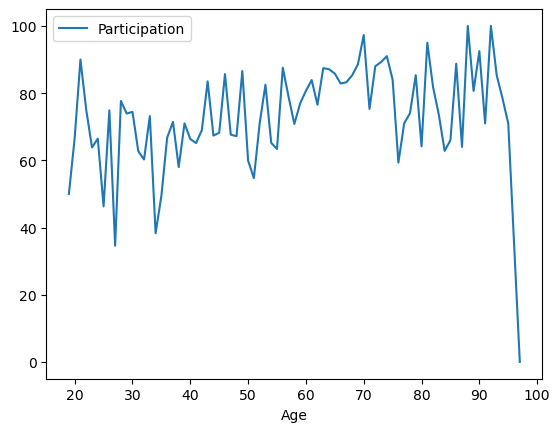

In [36]:
sample_df.groupby(by=["Age"])[['Participation']].mean().plot()

<AxesSubplot:xlabel='Family_Head_Count'>

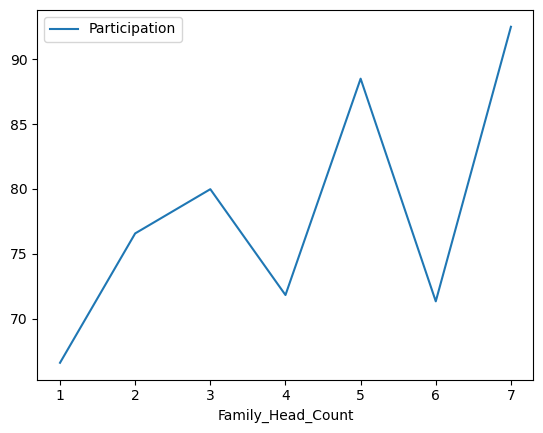

In [37]:
sample_df.groupby(by=["Family_Head_Count"])[['Participation']].mean().plot()

<AxesSubplot:xlabel='ISPSA'>

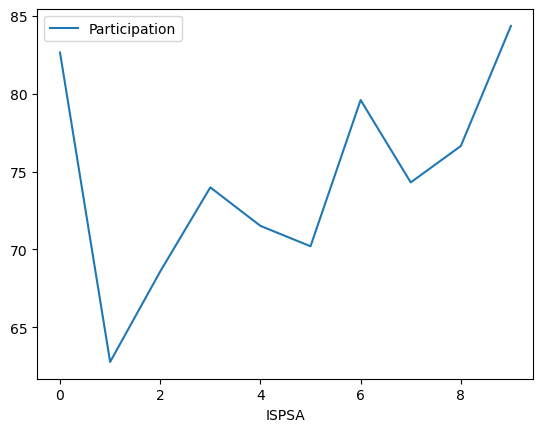

In [38]:
sample_df.groupby(by=["ISPSA"])[['Participation']].mean().plot()

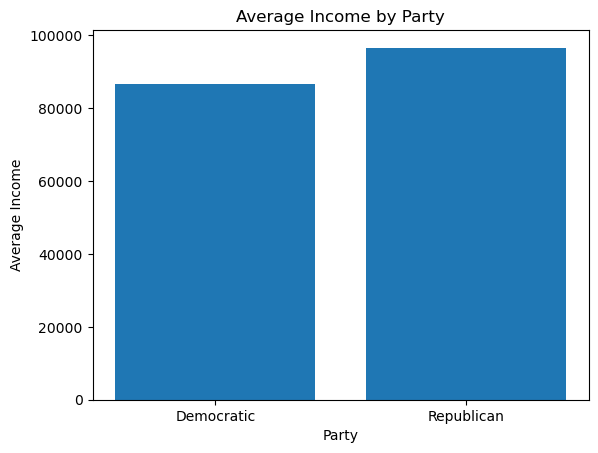

In [39]:
import matplotlib.pyplot as plt
sample_mean = sample_df.groupby('Party')['Income'].mean().reset_index()

plt.bar(sample_mean['Party'], sample_mean['Income'])
plt.xlabel('Party')
plt.ylabel('Average Income')
plt.title('Average Income by Party')
plt.show()

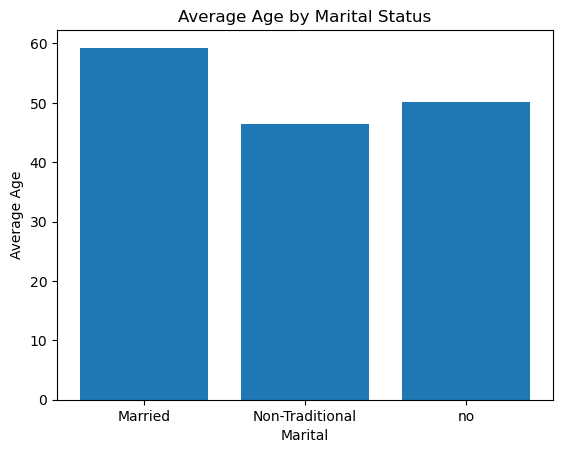

In [40]:
sample_mean2 = sample_df.groupby('Marital')['Age'].mean().reset_index()

plt.bar(sample_mean2['Marital'], sample_mean2['Age'])
plt.xlabel('Marital')
plt.ylabel('Average Age')
plt.title('Average Age by Marital Status')
plt.show()

In [41]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=[
    'Party_dummy', 'Age', 'Marital_dummy', 'Family_Head_Count', 'Ethnic_dummy', 'Income', 'ISPSA', 'Gun_ownership_dummy', \
    'Home_ownership_dummy'], outputCol='New Data')

new_sample_df = sample_df.drop(columns=['Party', 'Marital', 'Ethnic', 'Gun_ownership', 'Home_ownership', 'Home_value'])
new_sample = spark.createDataFrame(new_sample_df)
new_df = assembler.transform(new_sample)
sample_train, sample_test = new_df.randomSplit([0.8, 0.2], seed=134)

regression = LinearRegression(labelCol='Participation', featuresCol = 'New Data')
regression = regression.fit(sample_train)
prediction = regression.transform(sample_test)

rmse_lr = RegressionEvaluator(labelCol='Participation').evaluate(prediction)
r2_lr = RegressionEvaluator(labelCol='Participation', metricName='r2').evaluate(prediction)
mse_lr = RegressionEvaluator(labelCol='Participation', metricName='mse').evaluate(prediction)

print("RMSE for Linear Regression: %g" % rmse_lr)
print("R-squared for Linear Regression: %g" % r2_lr)
print("Mean Squared Error for Linear Regression: %g" % mse_lr)
print("Coefficients:", regression.coefficients)

24/03/18 21:49:07 WARN Instrumentation: [3316b22e] regParam is zero, which might cause numerical instability and overfitting.


RMSE for Linear Regression: 26.624
R-squared for Linear Regression: 0.0658797
Mean Squared Error for Linear Regression: 708.836
Coefficients: [2.100842824396812,0.2699272243735195,-3.728072524431893,1.6034823079917722,2.952448673768281,-2.643654786420981,-1.060829480730093,-5.383568373666282,0.11619231393012146,5.744554822154949e-05,0.40770005053328373,-4.295334536995873,7.260674232245189,7.4951196766424015]


In [69]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(labelCol='Participation', featuresCol='New Data', numTrees = 10)
rf_model = rf.fit(sample_train)
rf_predictions = rf_model.transform(sample_test)

rmse_rf = RegressionEvaluator(labelCol='Participation').evaluate(rf_predictions)
r2_rf = RegressionEvaluator(labelCol='Participation', metricName='r2').evaluate(rf_predictions)
mse_rf = RegressionEvaluator(labelCol='Participation', metricName='mse').evaluate(rf_predictions)

print("RMSE for Random Forest Regression: %g" % rmse_rf)
print("R-squared for Random Forest Regression: %g" % r2_rf)
print("Mean Squared Error for Random Forest Regression: %g" % mse_rf)
print("Features of Importance:", rf_model.featureImportances)

RMSE for Random Forest Regression: 26.3327
R-squared for Random Forest Regression: 0.0862076
Mean Squared Error for Random Forest Regression: 693.41
Features of Importance: (14,[0,1,2,3,4,5,6,7,8,9,10,11,12,13],[0.030755643209142904,0.3005685131366359,0.05293001415432713,0.025152962135343765,0.05668594233149421,0.01035365630342367,0.02329664794458962,0.010385645109989034,0.026939590455424968,0.23608874526377366,0.12764596053267033,0.03769152645516131,0.03979006407332447,0.02171508889469915])


In [70]:
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(labelCol='Participation', featuresCol='New Data')
dt_model = dt.fit(sample_train)
dt_predictions = dt_model.transform(sample_test)

rmse_dt = RegressionEvaluator(labelCol='Participation').evaluate(dt_predictions)
r2_dt = RegressionEvaluator(labelCol='Participation', metricName='r2').evaluate(dt_predictions)
mse_dt = RegressionEvaluator(labelCol='Participation', metricName='mse').evaluate(dt_predictions)

print("RMSE for Decision Tree Regression: %g" % rmse_dt)
print("R-squared for Decision Tree Regression: %g" % r2_dt)
print("Mean Squared Error for Decision Tree Regression: %g" % mse_dt)
print("Features of Importance:", dt_model.featureImportances)

RMSE for Decision Tree Regression: 30.3093
R-squared for Decision Tree Regression: -0.21062
Mean Squared Error for Decision Tree Regression: 918.651
Features of Importance: (14,[0,1,2,4,8,9,10,11,12,13],[0.02463752137773786,0.2870299830578729,0.05650216874212615,0.13606264954351635,0.0012318760688868932,0.362103182494346,0.08056823815953423,0.021824861702102873,0.022155512013000485,0.007884006840876118])


In [68]:
corr = sample_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,Participation,Age,Family_Head_Count,Income,ISPSA,Home_value
Participation,1.000000,0.201746,0.131241,0.134801,0.102892,0.160212
Age,0.201746,1.000000,-0.172232,-0.102586,0.063990,0.009132
Family_Head_Count,0.131241,-0.172232,1.000000,0.286762,0.127943,0.256046
Income,0.134801,-0.102586,0.286762,1.000000,0.438773,0.612768
ISPSA,0.102892,0.063990,0.127943,0.438773,1.000000,0.526119
Home_value,0.160212,0.009132,0.256046,0.612768,0.526119,1.000000


We can see the strongest correlation with participation is age and then home value. But overall, the correlation is not that significant, meaning the factors are not that decisive in determining the voter turnout.